In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn.decomposition import NMF

suffix = "_with_acc"
from_WC = True
test = False

path_to_data_files ="/content/drive/MyDrive/Katy/heartProject/heartData/"

from google.colab import drive
drive.mount('/content/drive')

if from_WC:    
  path_for_wc = "/content/drive/MyDrive/Katy/heartProject/WC/"
else:
  path_to_data_files ="/content/drive/MyDrive/Katy/heartProject/heartData/"


path_for_NMF = "/content/drive/MyDrive/Katy/heartProject/NMF_nov28_remake/"

if os.path.isdir(path_for_NMF) :
  pass
else: os.mkdir(path_for_NMF)
if os.path.isdir(path_for_NMF+"/Run"+suffix) :
  pass
else: os.mkdir(path_for_NMF+"/Run"+suffix)






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_dict_df(  path_to_files ="/content/drive/MyDrive/Katy/heartProject/heartData/"):
  df_collection = {}
  Multindex_df = pd.DataFrame()
  with os.scandir(path_to_files) as entries:
    for entry in entries:
          print(entry.name)
          file_path = path_to_files + entry.name
          if test:
            df_collection[entry.name] = pd.read_csv(file_path).transpose()[300:460] 
          else:
            df_collection[entry.name] = pd.read_csv(file_path).transpose()
          print(df_collection[entry.name].shape)
          ncol = len(df_collection[entry.name].columns)
  return df_collection

In [ ]:
# df_collection.keys

In [ ]:



def prepare_and_stack_df(df):
  df_numeric = df.iloc[:,4:]
  df_legend = df.iloc[:,3:4]
  df_all = df_legend.join(df_numeric).reset_index(drop=True)
  l = list(range(int(len(df_all)/2)))
  df_index = pd.DataFrame([val for pair in zip(l, l) for val in pair])

  df_all = df_index.join(df_all)
  df_all = df_all.pivot(index=0, columns = 3).astype('float').round(2)
  
  df_stacked = df_all.stack(0)

  return df_stacked

def create_nmf_matrix(df_collection):
  
  common_values = get_m_z_best_values(df_collection)
  print(common_values)
  matrix = []
  first= True
  for [key,df] in df_collection.items():
    print(key)
    df_stacked = prepare_and_stack_df(df)
    # print(df_stacked)
    grou = df_stacked.groupby(by=[0,'m/z'],axis=0)
    
    matrix=  df_stacked.groupby(by=[0,'m/z'],axis=0).sum().unstack(0).reindex(common_values)
    # print(matrix)

    # common_2 = np.round(common_values)
    # #grou_2 = df_stacked.groupby(by=[0,'m/z'],axis=0)
    
    # matrix_2=  df_stacked.groupby(by=[0,'m/z'],axis=0).sum().unstack(0).reindex(common_2)
    # print(matrix_2)
                            
    if first :
      matrix_all = matrix#.add_suffix(key)
      first = False
    else:
      matrix_all = matrix_all.join(matrix, how='left', rsuffix=key)

  return matrix_all, common_values  

def find_common_peaks(df_stacked):
 
  grouped = df_stacked.groupby(by=[0,'m/z'],axis=0).sum().groupby(by = 'm/z')
  
  sorted_peaks = grouped.sum().sort_values(by='Intensity')
  
  most_common_peaks = np.array(grouped.count().nlargest(1000,'Intensity').index)   #### most common peaks
  highest_peaks = np.array(grouped.sum().nlargest(300,'Intensity').index)    ### highest peaks ########## 300
  #high_common_peaks = np.intersect1d(most_common_peaks,highest_peaks)    ### both largest and most common
  return most_common_peaks    ############# change back to highest?


In [ ]:

### get the set of highest and most common m/z values to be used in nmf matrix

def get_m_z_best_values(df_collection):
  allpeaks = np.empty(0)
  for [key,df] in df_collection.items():
    
    df_stacked = prepare_and_stack_df(df)
    peaks = find_common_peaks(df_stacked)
    allpeaks = np.append(allpeaks,peaks)
   
  return np.unique(allpeaks)

 


In [ ]:
def get_tag_array(length,test = False):
  sick_healthy_array= np.zeros(length)
  if test:
    sick_healthy_array[0:80+66] = 1
  else:
    sick_healthy_array[0:552+432] = 1
  return sick_healthy_array


In [ ]:
#sick_healthy_array.shape


In [ ]:
from sklearn.linear_model import LogisticRegression
 

def get_LR_max(X,y):

  
  clf25 = LogisticRegression(random_state=0,max_iter=50000).fit(X, y)
  
  print(clf25.score(X, y)) 
  print("LR_max_channel:")
  print(np.argmax(clf25.coef_,axis = 1))
  print(np.argmin(clf25.coef_,axis = 1))


  LR_max_1 = np.argmax(np.abs(clf25.coef_/np.std(X, 0)),axis = 1)
  LR_max_2 = np.argmax(np.abs(clf25.coef_),axis = 1)
  return LR_max_1[0], LR_max_2[0]

In [ ]:
from sklearn.preprocessing import normalize

def get_cor_max(W,difficulty):
  max_cor = 0
  W_n = normalize(W,axis = 1)

  for i,col in enumerate(W.T):
    cor = np.corrcoef(col,difficulty,rowvar=False)[1,0]

    if np.abs(cor) > np.abs(max_cor):
      max_cor  = cor
      max_channel_1 = i
 

  max_cor = 0
  for i,col in enumerate(W_n.T):
    cor = np.corrcoef(col,difficulty,rowvar=False)[1,0]
    if np.abs(cor) > np.abs(max_cor):
      max_cor  = cor
      max_channel_2 = i
  print("cor_max_channel_normalized:")
  print(max_channel_2)    

  return max_channel_1, max_channel_2  


In [ ]:
best_10 = [124,79.95,253.2,327.25,281.25,282.25,309.3,113,451.3,303.25]
best_30 = [790.55,311.15,329.25,284.25,283.25,299.2,304.25,89,328.25,255.25,331.25,307.25,326.2,427.3,227.2,183,297.25,277.2,453.3,280.25,325.2,339.2,256.25,885.55,115,279.25,305.25]


#def score_parameter_choice(th,k,LR_max_1, LR_max_2,cor_max_1,cor_max_2,important_1_1,important_1_2,important_2,important_3 ):
def score_parameter_choice(th,k,important_1_1,important_1_2,important_2,important_3 ):

  #### how many from high 10
  cor_score_1 = np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_1_1[0],20)))/20,best_10))
  cor_score_2 = np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_1_2[0],20)))/20,best_10))

  L1_score = np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_2[0],20)))/20,best_10))
  L2_score = np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_3[0],20)))/20,best_10))
  best_10_score = [cor_score_1,cor_score_2,L1_score,L2_score]
#  print(np.sum((l-0.05<important_1<l+0.05) for l,r in best_10 ))
  ####### how many from high30
  cor_score_1 += np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_1_1[0],20)))/20,best_30))
  cor_score_2 += np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_1_2[0],20)))/20,best_30))

  L1_score += np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_2[0],20)))/20,best_30))
  L2_score += np.count_nonzero(np.intersect1d(np.unique(np.round(np.multiply(important_3[0],20)))/20,best_30))
  best_30_score = [cor_score_1,cor_score_2,L1_score,L2_score]
  print("k: "+str(k) +  ", th: " + str(th)+",  best 10 score: "+ str(best_10_score)+ ", best 30 score: "+ str(best_30_score) )  


  return best_10_score, best_30_score



In [ ]:
########### only relevant after saving W/H files to drive #############

import os, re
def get_W_H_from_files(k):
  regex_w = re.compile("W"+str(k)+"_.+csv$")
  regex_c = re.compile("C"+str(k)+"_.+csv$")
  W,C ,l,peaks= 0,0,0,[]
  print(path_for_wc)
  for subdir, dirs, files in os.walk(path_for_wc):
    if files == None: 
      print("cannot open directory")
    print(files)
    #print(W)
    for f in files:
      if regex_w.match(str(f)):
        print("match: " , f)
        W = np.loadtxt(path_for_wc + f ,delimiter=',') 
        length = W.shape[0]
      if regex_c.match(str(f)):
        print("match: " , f)
        C = np.loadtxt(path_for_wc + f ,delimiter=',') 
        H_new = C
        peaks = C[0,:]
        H = np.delete(C,0,axis=0)
        #print(C)
        #print(H)
    if np.all(W==0):
      print(k ," not fuond in folder")
    return [W ,H,H_new ,peaks, length]



/content/drive/MyDrive/Katy/heartProject/WC/
['W3_graphs.csv', 'C3_graphs.csv', 'W6_graphs.csv', 'C6_graphs.csv', 'W9_graphs.csv', 'C9_graphs.csv', 'W12_graphs.csv', 'C12_graphs.csv', 'W15_graphs.csv', 'C15_graphs.csv', 'W18_graphs.csv', 'C18_graphs.csv', 'W21_graphs.csv', 'C21_graphs.csv', 'W24_graphs.csv', 'C24_graphs.csv', 'W27_graphs.csv', 'C27_graphs.csv', 'W30_graphs.csv', 'C30_graphs.csv', 'W33_graphs.csv', 'C33_graphs.csv', 'W36_graphs.csv', 'C36_graphs.csv', 'W39_graphs.csv', 'C39_graphs.csv', 'W42_graphs.csv', 'C42_graphs.csv', 'W45_graphs.csv', 'C45_graphs.csv', 'W48_graphs.csv', 'C48_graphs.csv', 'W51_graphs.csv', 'C51_graphs.csv', 'W54_graphs.csv', 'C54_graphs.csv', 'W57_graphs.csv', 'C57_graphs.csv', 'W60_graphs.csv', 'C60_graphs.csv', 'W63_graphs.csv', 'C63_graphs.csv', 'W66_graphs.csv', 'C66_graphs.csv', 'W69_graphs.csv', 'C69_graphs.csv', 'W72_graphs.csv', 'C72_graphs.csv', 'W75_graphs.csv', 'C75_graphs.csv']
match:  W3_graphs.csv
match:  C3_graphs.csv


In [ ]:
if from_WC:
  pass
else:
  df_collection = create_dict_df()

  mat_all , peaks_all= create_nmf_matrix(df_collection)
  nmf_np = mat_all.fillna(0).to_numpy()
  print(mat_all.head(10))
  print(mat_all.shape)

In [ ]:
num_of_channels = [3,76]
thresholds = [-37]


NMF_all_W_H = {}
count_peaks_cor ,count_peaks_LR = [],[]
score_array_all =None


for k in range(num_of_channels[0],num_of_channels[1],3):

    print("**********",k," Channels **********************")
    if from_WC:
      [W ,H,H_new ,peaks, l] = get_W_H_from_files(k)  
      l = W.shape[0]
    else:
      nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
      W = nmf.fit_transform(nmf_np.transpose())
      H = nmf.components_
      H_new = np.concatenate((peaks_all.reshape(1,-1),H))
      l = W.shape[0]
      NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    sick_healthy_array = get_tag_array(l)
    LR_max_1, LR_max_2 = get_LR_max(W,sick_healthy_array)
    cor_max_1, cor_max_2 = get_cor_max(W,sick_healthy_array)

    if from_WC:
      pass
    else:
      file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
      np.savetxt(file_path_weights, X = W, delimiter=",")
      file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
      np.savetxt(file_path_channels, X = H_new, delimiter=",")
      file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num_" + str(k)+suffix +".csv"
      np.savetxt(file_path_bestnum  , X = [LR_max_1,LR_max_2,cor_max_1, cor_max_2], delimiter=",")
               
    for th in thresholds:

      important_1_1 = [H_new[0,np.argpartition(H[cor_max_1,:], th)[th:] ],H[cor_max_1,np.argpartition(H[cor_max_1,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1_1, delimiter=",")
      
      important_1_2 = [H_new[0,np.argpartition(H[cor_max_2,:], th)[th:] ],H[cor_max_2,np.argpartition(H[cor_max_2,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_CORNORM_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1_2, delimiter=",")
      
      important_2 = [H_new[0,np.argpartition(H[LR_max_1,:], th)[th:] ],H[LR_max_1,np.argpartition(H[LR_max_1,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_2, delimiter=",")
      
      important_3 = [H_new[0,np.argpartition(H[LR_max_2,:], th)[th:] ],H[LR_max_2,np.argpartition(H[LR_max_2,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over"+ str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_3, delimiter=",")

    
      score_10,score_30 = score_parameter_choice(th,k,important_1_1,important_1_2,important_2,important_3 )
            

      if th == -37:
        count_peaks_cor = np.concatenate((count_peaks_cor,important_1_1[0]))
        count_peaks_LR = np.concatenate((count_peaks_LR,important_3[0]))
        unique_cor, counts_cor = np.unique(count_peaks_cor, return_counts=True)
        unique_LR, counts_LR = np.unique(count_peaks_LR, return_counts=True)

        print(dict(zip(unique_cor, counts_LR)))
#        print(np.count(count_peaks_LR))
        
        print(dict(zip(unique_LR, counts_cor)))
        print("--------score array: ------")
        if np.all(score_array_all != None):
          score_array_all = np.vstack((score_array_all,np.hstack((score_10,score_30)).reshape((1,8))))
        else:  

          score_array_all = np.hstack((score_10,score_30)).reshape((1,8))

        print(score_array_all)
        
     #   sns.lineplot(data=score_array_all,   markers=True, dashes=False)

#
      if th == -10: 
        print(important_1_1[0])
        print(important_1_2[0])

        print(important_2[0])  
        print(important_3[0])


********** 3  Channels **********************
/content/drive/MyDrive/Katy/heartProject/WC/
['W3_graphs.csv', 'C3_graphs.csv', 'W6_graphs.csv', 'C6_graphs.csv', 'W9_graphs.csv', 'C9_graphs.csv', 'W12_graphs.csv', 'C12_graphs.csv', 'W15_graphs.csv', 'C15_graphs.csv', 'W18_graphs.csv', 'C18_graphs.csv', 'W21_graphs.csv', 'C21_graphs.csv', 'W24_graphs.csv', 'C24_graphs.csv', 'W27_graphs.csv', 'C27_graphs.csv', 'W30_graphs.csv', 'C30_graphs.csv', 'W33_graphs.csv', 'C33_graphs.csv', 'W36_graphs.csv', 'C36_graphs.csv', 'W39_graphs.csv', 'C39_graphs.csv', 'W42_graphs.csv', 'C42_graphs.csv', 'W45_graphs.csv', 'C45_graphs.csv', 'W48_graphs.csv', 'C48_graphs.csv', 'W51_graphs.csv', 'C51_graphs.csv', 'W54_graphs.csv', 'C54_graphs.csv', 'W57_graphs.csv', 'C57_graphs.csv', 'W60_graphs.csv', 'C60_graphs.csv', 'W63_graphs.csv', 'C63_graphs.csv', 'W66_graphs.csv', 'C66_graphs.csv', 'W69_graphs.csv', 'C69_graphs.csv', 'W72_graphs.csv', 'C72_graphs.csv', 'W75_graphs.csv', 'C75_graphs.csv']
match:  W3_gra

In [ ]:
# score_array_all = np.array([[10,10,10,10,34,31,34,34],
#                             [7,9,7,7,28,29,26,26],
#                             [6,7,8,8,27,21,26,26],
#                             [5,6,7,9,25,17,23,33],
#                             [2,7,6,6,20,25,25,25],
#                             [4,8,8,8,21,24,22,22],
#                             [4,8,7,7,24,25,22,22],
#                             [7,7,7,6,28,28,22,23],
#                             [3,8,8,8,16,30,32,32],
#                             [3,4,4,4,17,18,18,18],
#                             [4,4,8,8,20,20,29,29],
#                             [7,5,9,5,27,23,22,19],
#                             [5,5,6,9,24,24,26,23], 
#                             [ 5 , 2 , 6 , 6 ,26, 16, 28, 28],
#                             [ 7,  7,  8,  8, 26, 26, 21, 21],
#                             [ 6,  6,  6,  6, 24, 24, 20, 22],
#                             [ 2 , 1 , 7 , 7 ,19, 18, 21, 21],
#                             [ 5,  5,  7,  5, 22, 22, 20, 22],
#                             [ 7,  7,  8,  7, 29, 29, 18, 29],
#                             [ 7 , 7,  3,  3, 27, 27, 14, 14],
#                             [ 2,  7,  7,  7, 13, 25, 19, 28],
#                             [ 2,  2,  6,  6, 19, 19, 24, 26],
#                             [ 4,  4,  7,  7,  9, 19, 27, 27]])
# print(score_array_all.shape)


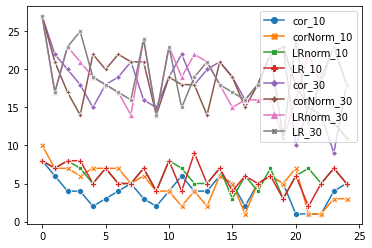

In [ ]:
df = pd.DataFrame(data = score_array_all,columns = ["cor_10","corNorm_10","LRnorm_10","LR_10","cor_30","corNorm_30","LRnorm_30","LR_30"])
sns.lineplot(data=df,   markers=True, dashes=False)#, legend=False)

### ***END of notebook ***

In [ ]:
num_of_channels = [78,100]
thresholds = [-300,-100,-50,-10]


NMF_all_W_H = {}
count_peaks_cor ,count_peaks_LR = [],[]
score_array_all =None


for k in range(num_of_channels[0],num_of_channels[1],3):

    print("**********",k," Channels **********************")
    if from_WC:
      [W ,H,H_new ,peaks, l] = get_W_H_from_files(k)  
      l = W.shape[0]
    else:
      nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
      W = nmf.fit_transform(nmf_np.transpose())
      H = nmf.components_
      H_new = np.concatenate((peaks_all.reshape(1,-1),H))
      l = W.shape[0]
      NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))

    sick_healthy_array = get_tag_array(l)
    LR_max_1, LR_max_2 = get_LR_max(W,sick_healthy_array)
    cor_max_1, cor_max_2 = get_cor_max(W,sick_healthy_array)

    if from_WC:
      pass
    else:
      file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
      np.savetxt(file_path_weights, X = W, delimiter=",")
      file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
      np.savetxt(file_path_channels, X = H_new, delimiter=",")
      file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num_" + str(k)+suffix +".csv"
      np.savetxt(file_path_bestnum  , X = [LR_max_1,LR_max_2,cor_max_1, cor_max_2], delimiter=",")
               
    for th in thresholds:

      important_1_1 = [H_new[0,np.argpartition(H[cor_max_1,:], th)[th:] ],H[cor_max_1,np.argpartition(H[cor_max_1,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1_1, delimiter=",")
      
      important_1_2 = [H_new[0,np.argpartition(H[cor_max_2,:], th)[th:] ],H[cor_max_2,np.argpartition(H[cor_max_2,:], th)[th:]]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_CORNORM_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1_2, delimiter=",")
      
      print(LR_max_1)
      print(H.shape)
      print(H[LR_max_1,:])
      important_2 = [H_new[0,np.argpartition(H[LR_max_1,:], th)[th:] ],H[LR_max_1,np.argpartition(H[LR_max_1,:], th)[th:]]]

      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_2, delimiter=",")
      
      important_3 = [H_new[0,np.argpartition(H[LR_max_2,:], th)[th:] ],H[LR_max_2,np.argpartition(H[LR_max_2,:], th)[th:]]]
      
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over"+ str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_3, delimiter=",")

      # print(len(important_1[0]))
      # print(len(important_2[0]))
      # print(len(important_3[0]))
      score_10,score_30 = score_parameter_choice(th,k,important_1_1,important_1_2,important_2,important_3 )
      #score_10_array = np.concatenate((score_10_array,[[score_10],[score_30]]))
      #30_score_array = np.concatenate((30_score_array,30_score))
      #sns.lineplot(data=score_10_array,    x="timepoint", y="signal", hue="event", style="event",   markers=True, dashes=False)
      #score_array = np.hstack((score_array,np.vstack((score_10,score_30))))

      #sns.lineplot(data=score_array,   markers=True, dashes=False)
      # score_array = 
      #score_array = np.vstack((score_array,np.hstack((score_10,score_30))))
      # print(score_10.shape)
      # print(score_30.shape)
      #print(np.hstack((score_10,score_30)).shape)
      #score_array_all  = np.empty([8])

      #print(score_array_all.shape)
      

      if th == -100:
        count_peaks_cor = np.concatenate((count_peaks_cor,important_1_1[0]))
        count_peaks_LR = np.concatenate((count_peaks_LR,important_3[0]))
        unique_cor, counts_cor = np.unique(count_peaks_cor, return_counts=True)
        unique_LR, counts_LR = np.unique(count_peaks_LR, return_counts=True)

        print(dict(zip(unique_cor, counts_LR)))
#        print(np.count(count_peaks_LR))
        
        print(dict(zip(unique_LR, counts_cor)))
        print("--------score array: ------")
        if np.all(score_array_all != None):
          score_array_all = np.vstack((score_array_all,np.hstack((score_10,score_30)).reshape((1,8))))
        else:  

          score_array_all = np.hstack((score_10,score_30)).reshape((1,8))

        print(score_array_all)
        
        sns.lineplot(data=score_array_all,   markers=True, dashes=False)

#
      if th == -10: 
        print(important_1_1[0])
        print(important_1_2[0])

        print(important_2[0])  
        print(important_3[0])

      # print(np.intersect1d(important_1,important_2).shape)
      # print(np.intersect1d(important_1,important_3).shape)
      # print(np.intersect1d(important_3,important_2).shape)



In [ ]:
score_array_all = np.empty([8])
print(score_array.shape)
print(score_10)
print(np.hstack((score_10,score_30)).shape)
#score_array = np.stack((score_array,np.hstack((score_10,score_30))))
#score_array = np.vstack((score_array,np.hstack((score_10,score_30))))
print(score_array_all.shape)
score_array_all = np.stack((score_array_all,np.hstack((score_10,score_30))))
print(score_array_all)


In [ ]:
score_array_all


In [ ]:
sns.lineplot(data=score_array_all,   markers=True, dashes=False)

In [ ]:
print(score_10)
print(score_30)
a = np.vstack((score_10,score_30))

sns.lineplot(data=a,   markers=True, dashes=False)

In [ ]:
print(np.argpartition(H[cor_max,:], -10)[-10:])


In [ ]:
best_10 = [124,79.95,253.2,327.25,281.25,282.25,309.3,113,451.3,303.25]
best_30 = [790.55,311.15,329.25,284.25,283.25,299.2,304.25,89,328.25,255.25,331.25,307.25,326.2,427.3,227.2,183,297.25,277.2,453.3,280.25,325.2,339.2,256.25,885.55,115,279.25,305.25]


In [ ]:
num_of_channels = [5,100]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}
thresholds = [0.1,1,100,700,1000]

 
for k in range(num_of_channels[0],num_of_channels[1],10):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    LR_max_1, LR_max_2 = get_LR_max(W,sick_healthy_array)
    cor_max = get_cor_max(W,sick_healthy_array)

    file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    np.savetxt(file_path_channels, X = H_new, delimiter=",")
    file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num_" + str(k)+suffix +".csv"
    np.savetxt(file_path_bestnum  , X = [LR_max_1,LR_max_2,cor_max], delimiter=",")
               
    for th in thresholds:


      important_1 = [H_new[0,H[cor_max,:]>th],H[cor_max,H[cor_max,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1, delimiter=",")
      
      important_2 = [H_new[0,H[LR_max_1,:]>th],H[LR_max_1,H[LR_max_1,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_2, delimiter=",")
      
      important_3 = [H_new[0,H[LR_max_2,:]>th],H[LR_max_2,H[LR_max_2,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over"+ str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_3, delimiter=",")

      print(len(important_1[0]))
      print(len(important_2[0]))
      print(len(important_3[0]))
      score_parater_choice(th,k,LR_max_1, LR_max_2,cor_max,important_1,important_2,important_3 )
      if th == 1000: 
        print(important_1[0])
        print(important_2[0])  
        print(important_3[0])
      # print(np.intersect1d(important_1,important_2).shape)
      # print(np.intersect1d(important_1,important_3).shape)
      # print(np.intersect1d(important_3,important_2).shape)



In [ ]:
num_of_channels = [5,100]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}
thresholds = [0.1,1,100,700,1000]

 
for k in range(num_of_channels[0],num_of_channels[1],10):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    LR_max_1, LR_max_2 = get_LR_max(W,sick_healthy_array)
    cor_max = get_cor_max(W,sick_healthy_array)

    file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    np.savetxt(file_path_channels, X = H_new, delimiter=",")
    file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num_" + str(k)+suffix +".csv"
    np.savetxt(file_path_bestnum  , X = [LR_max_1,LR_max_2,cor_max], delimiter=",")
               
    for th in thresholds:


      important_1 = [H_new[0,H[cor_max,:]>th],H[cor_max,H[cor_max,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1, delimiter=",")
      
      important_2 = [H_new[0,H[LR_max_1,:]>th],H[LR_max_1,H[LR_max_1,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_2, delimiter=",")
      
      important_3 = [H_new[0,H[LR_max_2,:]>th],H[LR_max_2,H[LR_max_2,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over"+ str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_3, delimiter=",")

      print(len(important_1[0]))
      print(len(important_2[0]))
      print(len(important_3[0]))
      score_parater_choice(th,k,LR_max_1, LR_max_2,cor_max,important_1,important_2,important_3 )

      # print(np.intersect1d(important_1,important_2).shape)
      # print(np.intersect1d(important_1,important_3).shape)
      # print(np.intersect1d(important_3,important_2).shape)



In [ ]:
num_of_channels = [3,100]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}
thresholds = [0.1,1,100,700,1000]

 
for k in range(num_of_channels[0],num_of_channels[1],10):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    LR_max_1, LR_max_2 = get_LR_max(W,sick_healthy_array)
    cor_max = get_cor_max(W,sick_healthy_array)

    file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    np.savetxt(file_path_channels, X = H_new, delimiter=",")
    file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num_" + str(k)+suffix +".csv"
    np.savetxt(file_path_bestnum  , X = [LR_max_1,LR_max_2,cor_max], delimiter=",")
               
    for th in thresholds:


      important_1 = [H_new[0,H[cor_max,:]>th],H[cor_max,H[cor_max,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(cor_max)+suffix +".csv"
      np.savetxt(file_path_important, X =important_1, delimiter=",")
      
      important_2 = [H_new[0,H[LR_max_1,:]>th],H[LR_max_1,H[LR_max_1,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over" + str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_1)+suffix +".csv"
      np.savetxt(file_path_important, X =important_2, delimiter=",")
      
      important_3 = [H_new[0,H[LR_max_2,:]>th],H[LR_max_2,H[LR_max_2,:]>th]]
      file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over"+ str(th)+"_Nchannels" + str(k)+"_channel"+ str(LR_max_2)+suffix +".csv"
      np.savetxt(file_path_important, X =important_3, delimiter=",")

      print(len(important_1[0]))
      print(len(important_2[0]))
      print(len(important_3[0]))

      print(np.intersect1d(important_1,important_2).shape)
      print(np.intersect1d(important_1,important_3).shape)
      print(np.intersect1d(important_3,important_2).shape)



In [ ]:
print j

In [ ]:
num_of_channels = [70,100]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}

 
for k in range(num_of_channels[0],num_of_channels[1],5):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=100000)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    LR_max_1, LR_max_2 = get_LR_max(NMF_all_W_H[k][0],sick_healthy_array)
    cor_max = get_cor_max(W,sick_healthy_array)

    file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    np.savetxt(file_path_channels, X = H_new, delimiter=",")
    file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num" + str(k)+suffix +".csv"
    np.savetxt(file_path_bestnum, X = [LR_max_1 ,LR_max_2,cor_max], delimiter=",")
   

    important_1 = H_new[0,H[cor_max,:]>1]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over1" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_1, delimiter=",")
    
    important_2 = H_new[0,H[LR_max_1,:]>1]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over1" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_2, delimiter=",")
    
    important_3 = H_new[0,H[LR_max_2,:]>1]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over1" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_3, delimiter=",")

    print(important_1.shape)

    print(np.intersect1d(important_1,important_2).shape)

    print(np.intersect1d(important_1,important_3).shape)

    print(np.intersect1d(important_3,important_2).shape)


    important_1 = H_new[0,H[cor_max,:]>3]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_COR_over3" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_1, delimiter=",")
    
    important_2 = H_new[0,H[LR_max_1,:]>3]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LRSTD_over3" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_2, delimiter=",")
    
    important_3 = H_new[0,H[LR_max_2,:]>3]
    file_path_important = path_for_NMF+"/Run"+suffix +"/important_peaks_LR_over3" + str(k)+suffix +".csv"
    np.savetxt(file_path_important, X =important_3, delimiter=",")

    print(important_1.shape)

    print(np.intersect1d(important_1,important_2).shape)

    print(np.intersect1d(important_1,important_3).shape)

    print(np.intersect1d(important_3,important_2).shape)


    # file_path_maxarray =  path_for_NMF+"/Run"+suffix +"/max_array" + str(k)+suffix +".csv"
    # np.savetxt(file_path_maxarray, X = max_array, delimiter=",")
    # file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num" + str(k)+suffix +".csv"
    # np.savetxt(file_path_bestnum, X = [max_max +num_of_channels[0],max_array[max_max],max_channel], delimiter=",")
    
    # #print(H.round(1))
    # file_path_weights = path_for_NMF +"weights"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF +"channels" + suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H, delimiter=",")

# indices = mat_all.index.to_numpy()
# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

In [ ]:
num_of_channels = [4,40]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}


for k in range(num_of_channels[0],num_of_channels[1]):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    get_LR_max(NMF_all_W_H[k][0],sick_healthy_array)
    get_cor_max(W,sick_healthy_array)

    # file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H_new, delimiter=",")
    # file_path_maxarray =  path_for_NMF+"/Run"+suffix +"/max_array" + str(k)+suffix +".csv"
    # np.savetxt(file_path_maxarray, X = max_array, delimiter=",")
    # file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num" + str(k)+suffix +".csv"
    # np.savetxt(file_path_bestnum, X = [max_max +num_of_channels[0],max_array[max_max],max_channel], delimiter=",")
    
    # #print(H.round(1))
    # file_path_weights = path_for_NMF +"weights"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF +"channels" + suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H, delimiter=",")

# indices = mat_all.index.to_numpy()
# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

In [ ]:
num_of_channels = [34,55]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
NMF_all_W_H = {}


for k in range(num_of_channels[0],num_of_channels[1]):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    get_LR_max(NMF_all_W_H[k][0],sick_healthy_array)
    get_cor_max(W,sick_healthy_array)

    # file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H_new, delimiter=",")
    # file_path_maxarray =  path_for_NMF+"/Run"+suffix +"/max_array" + str(k)+suffix +".csv"
    # np.savetxt(file_path_maxarray, X = max_array, delimiter=",")
    # file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num" + str(k)+suffix +".csv"
    # np.savetxt(file_path_bestnum, X = [max_max +num_of_channels[0],max_array[max_max],max_channel], delimiter=",")
    
    # #print(H.round(1))
    # file_path_weights = path_for_NMF +"weights"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF +"channels" + suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H, delimiter=",")

# indices = mat_all.index.to_numpy()
# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

In [ ]:
num_of_channels = [55,70]
nmf_np = mat_all.fillna(0).to_numpy()
from sklearn.decomposition import NMF
#NMF_all_W_H = {}


for k in range(num_of_channels[0],num_of_channels[1]):

    print("**********",k," Channels **********************")
    nmf = NMF(n_components=k, init='nndsvd', random_state=0,max_iter=10000)
    W = nmf.fit_transform(nmf_np.transpose())
    H = nmf.components_
    H_new = np.concatenate((peaks_all.reshape(1,-1),H))

    NMF_all_W_H[k] = [W,H]
    #print(W.round(2))

    #print(np.count_nonzero(W.round(2), axis=0))


    get_LR_max(NMF_all_W_H[k][0],sick_healthy_array)
    get_cor_max(W,sick_healthy_array)

    file_path_weights = path_for_NMF+"/Run"+suffix +"/W" + str(k)+suffix +".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF+"/Run"+suffix +"/C" + str(k)+suffix +".csv"
    np.savetxt(file_path_channels, X = H_new, delimiter=",")
    # file_path_maxarray =  path_for_NMF+"/Run"+suffix +"/max_array" + str(k)+suffix +".csv"
    # np.savetxt(file_path_maxarray, X = max_array, delimiter=",")
    # file_path_bestnum = path_for_NMF+"/Run"+suffix +"/best_channels_num" + str(k)+suffix +".csv"
    # np.savetxt(file_path_bestnum, X = [max_max +num_of_channels[0],max_array[max_max],max_channel], delimiter=",")
    
    # #print(H.round(1))
    # file_path_weights = path_for_NMF +"weights"+suffix +"/W" + str(k)+suffix +".csv"
    # np.savetxt(file_path_weights, X = W, delimiter=",")
    # file_path_channels =  path_for_NMF +"channels" + suffix +"/C" + str(k)+suffix +".csv"
    # np.savetxt(file_path_channels, X = H, delimiter=",")

# indices = mat_all.index.to_numpy()
# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

In [ ]:
X[:,13]

In [ ]:
[W,H] = NMF_all_W_H[39]
# max_cor = 0
for i,col in enumerate(H):
  important_peaks = peaks_all[np.argwhere(H[i,:]>100)]
  print(important_peaks.reshape([1,-1]))
  print(i)
  if 124 in important_peaks: print("*********")
  if 113.1 in important_peaks: print("*********")

    #cor = np.corrcoef(col,sick_healthy_array,rowvar=False)[1,0]
   # print(cor)
    #cor2 = np.correlate(col,sick_healthy_array)
    # if np.abs(cor)> max_cor:
    #   max_index = i
    #   max_cor = np.abs(cor)
    #   print(i)

important_peaks = np.argwhere(H[13,:]>100)
#np.max(H[0,:])
# indices[important_peaks]

# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

# file_path_peaks = path_for_NMF +"weights"+suffix +"/peaks_300common_3"+suffix +".csv"
# np.savetxt(file_path_peaks, X = indices[important_peaks], delimiter=",")
# print(indices[important_peaks])

In [ ]:
from sklearn.linear_model import LogisticRegression

sick_healthy_array = np.zeros(mat_all.shape[1])

sick_healthy_array[0:493] = 1


X = NMF_all_W_H[39][0]
y = sick_healthy_array

clf37 = LogisticRegression(random_state=0,max_iter=5000).fit(X, y)
print(clf37.score(X, y))
  # print(clf25.coef_)
importance = np.std(X, 0)*clf37.coef_
print(importance)
print(np.max(np.abs(importance)))
print(np.argmax(np.abs(importance)))

print(np.max(importance))
print(np.argmax(importance))
 # print("**************")
#X.shape

In [ ]:
[W,H] = NMF_all_W_H[39]

cor_array = []
for i,col in enumerate(W.T):
  #important_peaks = peaks_all[np.argwhere(H[i,:]>200)]
  #print(important_peaks.reshape([1,-1]))
  # print(i)
  #if 124 in important_peaks: print("*********")
 # if 113.1 in important_peaks: print("*********")

  cor = np.corrcoef(col,sick_healthy_array,rowvar=False)[1,0]
  cor_array = np.append(cor_array,cor)
print(cor_array)
print(np.argmax(cor_array))

print(np.argmax(np.abs(cor_array)))

In [ ]:


for k in NMF_all_W_H.keys():
  X = NMF_all_W_H[k][0]
  y = sick_healthy_array
  clf25 = LogisticRegression(random_state=0,max_iter=5000).fit(X, y)
  # clf25.predict(X[:2, :])
  # array([0, 0])
  # clf25.predict_proba(X[:2, :])
  # array([[9.8...e-01, 1.8...e-02, 1.4...e-08],
  #        [9.7...e-01, 2.8...e-02, ...e-08]])
  print(clf25.score(X, y))
  # print(clf25.coef_)
  print(np.std(X, 0)*clf25.coef_)
  print(np.max(np.abs(np.std(X, 0)*clf25.coef_)))
  print(np.argmax(np.abs(np.std(X, 0)*clf25.coef_)))

  print("**************")

In [ ]:
LR_importance = np.std(X, 0)*clf25.coef_
max_LR_imp = np.argmax(LR_importance)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(train[:2, :])
# array([0, 0])
clf.predict_proba(X[:2, :])
# array([[9.8...e-01, 1.8...e-02, 1.4...e-08],
#        [9.7...e-01, 2.8...e-02, ...e-08]])
clf.score(X, y)

In [ ]:




def get_max_corelated_channel(NMF_all_W_H,sick_healthy_array):
  max_array = []

  for (k,[W,H]) in NMF_all_W_H.items():
    #print(W)
    #print(k)
    max_cor = 0
    for i,col in enumerate(W.T):
      cor = np.corrcoef(col,sick_healthy_array,rowvar=False)[1,0]
    # print(cor)
      #cor2 = np.correlate(col,sick_healthy_array)
      max_cor = max(max_cor,np.abs(cor))

    #print("**********")
    max_array = np.append(max_array,max_cor)
    #print(max_cor)
    #print("**********")
  #print(max_max)
      #print(cor2/2130)#if np.
  print(max_array)
  max_max = np.argmax(max_array)

  print(max_max)
  print(max_array[max_max])
  return max_max

In [ ]:
train[:2, :]
y[:2]

In [ ]:
m.fit(X / np.std(X, 0), y)


In [ ]:
print(important_peaks.shape)
print(important_peaks)

In [ ]:
max_max = get_max_corelated_channel(NMF_all_W_H,sick_healthy_array)

[W,H] = NMF_all_W_H[max_max+list(NMF_all_W_H.keys())[0]]
max_cor = 0
for i,col in enumerate(W.T):
    cor = np.corrcoef(col,sick_healthy_array,rowvar=False)[1,0]

   # print(cor)
    #cor2 = np.correlate(col,sick_healthy_array)
    if np.abs(cor)> max_cor:
      max_index = i
      max_cor = np.abs(cor)
      print(i)

important_peaks = np.argwhere(H[0,:]>3)
#np.max(H[0,:])
# indices[important_peaks]

# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

# file_path_peaks = path_for_NMF +"weights"+suffix +"/peaks_300common_3"+suffix +".csv"
# np.savetxt(file_path_peaks, X = indices[important_peaks], delimiter=",")
# print(indices[important_peaks])

In [ ]:
max_index

In [ ]:
healthy_sick_array = np.zeros(mat_all.shape[1])

healthy_sick_array[493:] = 1

max_array = []

for (k,[W,H]) in NMF_all_W_H.items():
  #print(W)
  print(k)
  max_cor = 0
  for i,col in enumerate(W.T):
    cor = np.corrcoef(col,healthy_sick_array,rowvar=False)[1,0]
   # print(cor)
    #cor2 = np.correlate(col,sick_healthy_array)
    max_cor = max(max_cor,np.abs(cor))
    
  #print("**********")
  max_array = np.append(max_array,max_cor)
  print(max_cor)
  print("**********")
#print(max_max)
    #print(cor2/2130)#if np.

max_max = np.argmax(max_array)

[W,H] = NMF_all_W_H[max_max]
max_cor = 0
for i,col in enumerate(W.T):
    cor = np.corrcoef(col,healthy_sick_array,rowvar=False)[1,0]
   # print(cor)
    #cor2 = np.correlate(col,sick_healthy_array)
    if np.abs(cor)> max_cor:
      max_index = i
      max_cor = np.abs(cor)
      print(i)

important_peaks_h = np.argwhere(H[0,:]>30)
#np.max(H[0,:])
indices[important_peaks_h]

# file_path_indices = path_for_NMF +"weights"+suffix +"/indices"+suffix +".csv"
# np.savetxt(file_path_indices, X = indices, delimiter=",")

file_path_peaks = path_for_NMF +"weights"+suffix +"/peaks_h"+suffix +".csv"
np.savetxt(file_path_peaks, X = indices[important_peaks_h], delimiter=",")

In [ ]:
print(indices[important_peaks_h])
print(indices[important_peaks])

END OF NOTEBOOK

In [ ]:
all_M_Z = get_m_z_best_values(df_collection)


In [ ]:
#peaks,a, mat = find_common_peaks_and_matrix(df_collection['INFARCT-FULL_peaks.csv'])

print(mat.shape)
#mat[('m/z',50.2)]
#mat.head
#mat.columns
mat.loc[50.2]
print(mat.reindex(all_M_Z).shape)
print(mat.reindex(all_M_Z).head)

In [ ]:
nmf_df = pd.DataFrame(columns=all_M_Z, index =pd.MultiIndex.from_tuples([("a",1)]))


In [ ]:

# for [key,df] in df_collection.items():
    
#     peaks[key],all_grouped[key], all = find_common_peaks(df)
#     allpeaks = np.append(allpeaks,peaks[key])
#     #print(peaks.size)
#     print(all.head)
#     #print(df.head)

for [key,df] in df_collection.items():
    print(key)
    print(df.shape)
    print(nmf_df.shape)
    peaks,all_grouped, all = find_common_peaks(df)
    #allpeaks = np.append(allpeaks,peaks[key])
    for j, col in df.iteritems():
      if j%1000 == 0: print(j)
      if j<4 : pass
      else:

        #nmf_df.loc[(key,j),all.loc[all.loc[:,(j,'m/z')].isin(all_M_Z),(j,'m/z')].values] = all.loc[all.loc[:,(j,'m/z')].isin(all_M_Z),(j,'Intensity')].values

    #print(peaks.size)
 #   print(all.head)
#     #print(df.head)
# i=1
# j=4
# for i in all.columns.size:
#   for j
#   i+=1
#   j+=1
#   nmf_df.loc[(i,j),all.loc[all.loc[:,(i+3,'m/z')].isin(all_M_Z),(i+3,'m/z')].values] = all.loc[all.loc[:,(i+3,'m/z')].isin(all_M_Z),(i+3,'Intensity')].values
#   if i%100 == 0 : print(i)

In [ ]:
all.dropna(1).count()

In [ ]:
df.shape

In [ ]:
nmf_df2 = nmf_df.copy()

In [ ]:
nmf_df2.head()

In [ ]:
nm

In [ ]:
file_path_mat =  path_for_NMF +"matrix/mat_df.csv"

nmf_df.to_csv(file_path_mat)

In [ ]:
#print(all)
nmf_df

In [ ]:
all_M_Z = np.unique(allpeaks)
nmf_df = pd.DataFrame(columns=all_M_Z, index = np.arange(3))

all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'Intensity')]
som_m_z = all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'m/z')].values[1]
#nmf_df.loc[0,all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'m/z')].values[1]]
# = all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'Intensity')
#nmf_df.columns == all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'m/z')].values[1]
print(som_m_z)
nmf_df.loc[1,som_m_z]
nmf_df.loc[1,all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'m/z')].values] = all.loc[all.loc[:,(4,'m/z')].isin(all_M_Z),(4,'Intensity')].values
#nmf_df = nmf_df.reindex(np.arange(arr.shape[0]))
nmf_df
i=4
for column in all:
  i+=1
  nmf_df.loc[i,all.loc[all.loc[:,(i,'m/z')].isin(all_M_Z),(i,'m/z')].values] = all.loc[all.loc[:,(i,'m/z')].isin(all_M_Z),(i,'Intensity')].values
  print(i)

nmf_df.head(20)
#all.head()

In [ ]:
nmf_df = nmf_df.fillna(0)
nmf_df.head(15)

In [ ]:
nmf_df = pd.DataFrame(columns=all_M_Z, index =pd.MultiIndex.from_tuples([("a",1),("a",2),("b",2)]))

#all.columns()
nmf_df.head

In [ ]:
#print(all.loc[:,(4,"m/z")] in all_M_Z)
#all.loc[all_M_Z,(4,"Intensity")]
#filter = all.loc[:,(4,"m/z")] in all_M_Z
all_1 = all
(all.loc[:,(4,"m/z")]>100).sum()#.isin( all_M_Z).sum()

In [ ]:

all_M_Z = np.unique(allpeaks)
nmf_df = pd.DataFrame(columns=all_M_Z)
for i,columns  in enumerate(all.columns):
  
  nmf_df.loc[i,all.loc[:,(i+4,"m/z")]] = all.loc[:,(i+4,"Intensity")]
  # print(all.size)
  # print(all_grouped.index)

In [ ]:
print(nmf_df.dropna(axis = 1, how = 'all').head())
print(nmf_df.columns)

In [ ]:
print(all_grouped.loc[peaks,:].values)#.pivot(index=0, columns = 3))
print("*********")
print(all_grouped.index)

In [ ]:
all_M_Z = np.unique(allpeaks)
nmf_df = pd.DataFrame(columns=all_M_Z)
nmf_df.loc[1,peaks] = all_grouped.loc[peaks,:].values.reshape(-1)
print(nmf_df.loc[:,peaks]  )#= NaN# all_grouped.loc[peaks]
#print(nmf_df)






In [ ]:
##### take 255 highest of all filesand all pixels and see if they intersect

#### take 255 highest and arrange their values in an NMF matrix

### run NMF and see what peaks come up

In [ ]:
print(df5.head(200))
#df6_ = df5.pivot_table(index=0, columns = 3)
# df5_ = df5.stack()
# print(df5_.head(1420))

In [ ]:
#g = df7#.groupby(level=df7.index.names)
#df11 = df10.groupby(by=[0,'m/z'],axis=0)
#df11.head(700)
df = df_collection['INFARCT-FULL_peaks.csv']
df_numeric = df.iloc[:,4:]
#print("**************")
#print(df_numeric.iloc[:,200:].head())#.astype('float')>100).sum())

df_legend = df.iloc[:,3:4]
df_all = df_legend.join(df_numeric).reset_index(drop=True)
#print(df_all.iloc[:,200:].head())#.astype('float')>100).sum())

l = list(range(int(len(df_all)/2)))
df_index = pd.DataFrame([val for pair in zip(l, l) for val in pair])

df_all = df_index.join(df_all)
#print((df_all>100).sum())
#print(df_all.iloc[:,200:].tail())#.astype('float')>100).sum())

df_all = df_all.pivot(index=0, columns = 3).astype('float').round(1)
print(df_all.head)
#print(df_all.iloc[:,200:].tail())#.astype('float')>100).sum())
df_stacked = df_all.stack(0)
print(df_stacked.head)
print(df_stacked.shape)

#print(len(df_all))
#print(df_all.head)
#df7 = df6.astype('float').round(2)
#df10 = df7.stack(0)
grou = df_stacked.groupby(by=[0,'m/z'],axis=0)
grouped = df_stacked.groupby(by=[0,'m/z'],axis=0).sum().groupby(by = 'm/z')
sumed = grou.sum().unstack()

print(sumed.head(20))


In [ ]:
print(sumed.shape)
#print(sumed.isna().sum(0))
grou = df_stacked.groupby(by=[0,'m/z'],axis=0)

print(grou.sum().unstack(0).head())

In [ ]:
for state, frame in grou:
    #print(f"First 2 entries for {state!r}")
    print("------------------------")
    print(frame.head(50), end="\n\n")


In [ ]:
df6.head()

In [ ]:
df8.head

In [ ]:
df10.head()

In [ ]:
for i

In [ ]:

##### fix / vhamgr

#### every 5 pixels are being meaned with each other + rounded up 
m = 8
l = list(range(m))
df4 = pd.DataFrame([val for pair in zip(l, l) for val in pair])
for i in range(int(160/(2*m))):   ##### does not cover all
  print(i)
  print("*********************")
  df_partial =  df3[0+i*2*m:2*m+i*2*m].reset_index()
  # print(df_partial.head())
  # print(df4.head())
  
  df5 = df4.join(df_partial)
  print(df5.head(5))
  
  df6 = df5.pivot(index=0, columns = 3)
  df7 = df6.astype('float').round(2)
  #df7.columns
  print(df7.head(20))

  # df8  = df7.iloc[0:20]

  df10 = df7.stack(0)
  print(df10.head(20))
  df11 = df10.groupby(by = 'm/z')
  #df11 = df10.groupby(level = [0])

  df12 = df11.sum()
  print(df12.head())
df_partial.head()

In [ ]:
l = list(range(80))
df4 = pd.DataFrame([val for pair in zip(l, l) for val in pair])
df5 = df4.join(df3)
#df5
df6 = df5.pivot(index=0, columns = 3)
df7 = df6.astype('float').round(1)
#df7.columns
print(df7.head(20))

df8  = df7.iloc[0:20]

df10 = df8.stack(0)
print(df10.head(20))
df11 = df10.groupby(by = 'm/z')
#df11 = df10.groupby(level = [0])

df12 = df11.sum()
print(df11.head)
print(df12.head(10))


#k = df7.index.names
#print(k)
#df7.groupby(level=df7.index.names).count()

#df8 = df7.groupby('m/z')
#df8


In [ ]:
df11 = df10.groupby(by = 'm/z')
df10.head(30)

In [ ]:
#df7.columns = df7.columns.str.strip(
df7#.pivot(columns=[4,:])


In [ ]:
# df6_ = df6.loc[1].astype('float').round(2)
# df6__= df6.loc[2].astype('float').round(2)

# df8 = df6_.groupby(level = 1)
# df10 = pd.DataFrame(df6_)



In [ ]:
 
def create_df_collection(  path_to_files ="/content/drive/MyDrive/Katy/heartProject/heartData/"):
  df_collection = {}
  with os.scandir(path_to_files) as entries:
      for entry in entries:
          print(entry.name)
          file_path = path_to_files + entry.name

        #f = open(file_path)
         # reader = csv.reader(f)
         # ncol = len(next(reader))
         

          #df2 = pd.read_csv(file_path)
          if test:
            df_collection[entry.name] = pd.read_csv(file_path).transpose()[300:460]  #### remove [0:50]
          else:
            df_collection[entry.name] = pd.read_csv(file_path).transpose()
          ncol = len(df_collection[entry.name].columns)
          l = ["c_{}".format(i) for i in range(ncol)]
          df_collection[entry.name].columns = l
  return df_collection

#df_collection[1390].head()

In [ ]:
# DF_matrix = pd.read_csv("/content/drive/MyDrive/Katy/heartProject/NMF_25_4_2021/matrix/8.csv")
# DF_matrix_np =np.fromfile("/content/drive/MyDrive/Katy/heartProject/NMF_25_4_2021/matrix/8.csv",dtype=float)

In [ ]:
# #DF_matrix.head()
# DF_matrix_np.shape
# DF_matrix_col = DF_matrix_np.reshape((-1,16624))[0]
# DF_matrix_col
# DF_matrix_np.reshape((-1,16624))[0]
# #file_path_matrics = path_for_NMF +"matrix/columns.csv"
# #np.savetxt(file_path_matrics, X =DF_matrix_np[0:16624]  , delimiter=",")

In [ ]:
def create_seperate_DF(df):
  ### creating DF of peaks values
  #print(df['c_1'])
  df_peaks = df[df['c_0'] != 'X']
  df_peaks = df_peaks.iloc[:,6:].copy().reset_index(drop = True)

  
  #df_peaks.head()
  ### creating DF of peaks positions
  df_positions = df[df['c_0'] == 'X']
  df_positions = df_positions.iloc[:,6:].copy().reset_index(drop = True)
  
  #df_positions
  DFs = [ df_positions, df_peaks]
  print(df_positions.head())
  print(df_peaks.head())

  return DFs

In [ ]:
### sum together close peaks (for single pixel) if m/z is as close as 0.025
def collect_close_peaks_of_NMFmat(M2Z_array ,NMFmat_copy):
  
  NMFmat = NMFmat_copy
  NMFmat_new = np.zeros_like(NMFmat_copy)
  NMFmat_new[:,0] += NMFmat[:,0]
  M2Z_array_new = np.array([])
  j = 0
  for i in range(len(M2Z_array)-1):
      NMFmat_new[:,j] += NMFmat[:,i]
      # if M2Z_array[i+1] == -1:
      #     print("$$$$$$$$$$$$$$$$$$$$$$") 
      # print()
      if M2Z_array[i+1]-M2Z_array[i]> 0.05:    #####0.025:
        
      #     #NMFmat[i,:] = np.nan   
      # else:
        #print([i,j])
        #print(M2Z_array_new)
        #print(M2Z_array[i])
        #NMFmat_new[:,j] += NMFmat[:,i]
        M2Z_array_new = np.concatenate([M2Z_array_new, [M2Z_array[i]]])
        j +=1

  NMFmat_new[:,j] += NMFmat[:,i]
  M2Z_array_new = np.concatenate([M2Z_array_new, [M2Z_array[i]]])    ### add last one 
  #print(NMFmat_new[0:5,0:12])

  idx = np.argwhere(np.all(NMFmat_new[..., :] == 0, axis=0))
  #print(NMFmat_new.shape)
  #print(idx2)
  #print(NMFmat_new[:,0:5].transpose())
  
  NMFmat_new = np.delete(NMFmat_new, idx, axis=1)
#  M2Z_array_new = np.delete(M2Z_array_new, idx)
  print(NMFmat_new.shape)
  print(M2Z_array_new.shape)
  
  
  idx2 = np.argwhere(np.all(np.isnan(NMFmat_new[..., :]), axis=0))

  NMFmat_new = np.delete(NMFmat_new, idx2, axis=1)
  M2Z_array_new = np.delete(M2Z_array_new, idx2)

  #idx = np.argwhere(np.all(NMFmat_new[..., :] == 0, axis=0))
  #idx2 = np.argwhere(np.all(np.isnan(NMFmat_new[..., :]), axis=0))
  #print("=============================")

  # print(idx)
  # print(idx2)
  #print(NMFmat_new.shape)
  #print(M2Z_array_new.shape)
  

 # print(i)
 # print(M2Z_array_new.shape)
 # print(NMFmat_new.shape)
  return M2Z_array_new, NMFmat_new


In [ ]:
def create_multinedx_NMF_df(df_collection_dict):
  for [key,df_i] in df_coll.items( ):
    print("***************************************")
    print(key)
    [pos, peaks] = create_seperate_DF(df_i)
    pos_np = pos.astype(float).to_numpy()
    peaks_np = peaks.astype(float).to_numpy()
    print(pos_np.shape)
    print(peaks_np.shape)



In [ ]:


def create_NMFmatrix_from_dict(df_collection_dict,path_to_csv  = "/content/drive/MyDrive/Katy/heartProject/CSV_high_peaks/"):
  M2z_dict = {}
  NMF_mat_dict = {}
  Label_dict = {}
  pos_u_all = np.array([])

  for [key,df_i] in df_coll.items( ):
    print("***************************************")
    print(key)
    [pos, peaks] = create_seperate_DF(df_i)
    pos_np = pos.astype(float).to_numpy()
    peaks_np = peaks.astype(float).to_numpy()
    print(pos_np.shape)
    print(peaks_np.shape)


    pos_u = np.unique(pos_np.reshape([-1]))
    
    #print(all_u.shape)
    pos_u = pos_u[~np.isnan(pos_u)]
    pos_round = pos_u.round()
    pos_round = np.unique(pos_round)
    print("unique values: " + str(pos_u.shape))
    print("rounded values: " + str(pos_round.shape))
      
    #print(pos_np.shape)
    #print(len(all_u))
    num_of_pixels = pos_np.shape[0]
#    num_of_unique_M2Z = len(pos_u)
    num_of_unique_M2Z = len(pos_round)

    print(num_of_pixels)
    #all_NMF_array = np.zeros(shape = [num_of_unique_M2Z,num_of_pixels])
    p#rint(all_NMF_array.shape)



    num_of_pixels = pos_np.shape[0]
    all_NMF_array = np.zeros(shape = [len(pos_round),num_of_pixels])

    for i,m2z in enumerate(pos_round) :
      all_NMF_array[i,np.where(pos_np==pos_u[i])[0]] = peaks_np[np.where(pos_np==pos_u[i])]
      if i % 5000 ==0 : 
        print("finished column " + str(i) + " of " + str(num_of_unique_M2Z) + " : " + str(i/num_of_unique_M2Z))


    all_NMF_array = all_NMF_array.transpose()
    print(all_NMF_array.shape)

      #### collect peaks which are close up to 0.025
    M2Z_new ,NMFmat_new = collect_close_peaks_of_NMFmat(pos_u, all_NMF_array)
      ####save to dictionary
    pos_u_all = np.concatenate([pos_u_all,pos_u])
    M2z_dict[key] = M2Z_new
    NMF_mat_dict[key] = NMFmat_new
    #print(key.lower())
    Label_dict[key] = 1 if "infarct" in key.lower() else 0

    # print("here******************************")
    # print(Label_dict)
    # print(M2Z_new.shape)
    # print(NMFmat_new.shape)
    
      ###save to file
    x = np.concatenate(([M2Z_new],NMFmat_new))

    file_path =path_for_NMF +"matrix/NMFmat_new_200_pixels_" + str(key)
    np.savetxt(file_path, X = x , delimiter=",")
  return M2z_dict, NMF_mat_dict, Label_dict



In [ ]:
# M2z_dic.keys()

In [ ]:
# #### If i already hace a csv of the NMF matrix..


# def create_DF_back_from_csv(path = path_for_saved_NMF_matrices):

#   df_dict = {}

#   with os.scandir(path) as entries:
#       for entry in entries:
#         print(entry.name)
#         file_path = path + entry.name
#         df_dict[entry.name] = pd.read_csv(file_path)
#         # print(df_dict[entry.name].head())
#         # print(df_dict[entry.name].shape)


#   return df_dict

In [ ]:
# ###check if NMF matrices are the same    ####TODO: remove later!!!
# np.set_printoptions(threshold=2000,precision = 2, suppress=True)

# #M2z_dic, NMF_mat_dic

# #### create dictionary for creating dataframe
# # df_dic = {}
# # #first= True
# # for (key,M2Z) in M2z_dic.items():
# #   df_dic[key] = pd.DataFrame(data = NMF_mat_dic[key], columns = M2Z)
# #   print(key)
# #   print(df_dic[key].shape)
# #   print(df_dic[key].head())

# temp_df_dic = {}
# #first= True
# for (key,M2Z) in M2z_dic.items():
#   temp_df_dic[key] = pd.DataFrame(data = NMF_mat_dic[key], columns = M2Z)
#   print(key)
#   print(temp_df_dic[key].shape)
#   print(temp_df_dic[key].head())

# np.set_printoptions(threshold=2000,precision = 2, suppress=True)

# df_dict_from_files= create_DF_back_from_csv()

# for (key,df) in df_dict_from_files.items():
#   print(key)
#   print(df.shape)
#   print(df.head())




In [ ]:


from sklearn.decomposition import NMF


#### create dictionary for creating dataframe

def merge_DFs_into_train_set(M2z_dic, NMF_mat_dic, Label_dic):
  df_dic = {}
  #first= True
  
###  DF_from_two_dictionaries(M2z_dic,NMF_mat_dic )   ##TODO : maybe turn into a function since i use several times - 
  for (key,M2Z) in M2z_dic.items():
    df_dic[key] = pd.DataFrame(data = NMF_mat_dic[key], columns = M2Z)
    #####################################
    df_dic[key][-1] = Label_dic[key] 
  ### create dataframe of all files

  df_all = pd.concat(df_dic.values(), axis = 0,keys = df_dic.keys() , ignore_index=True)  
  #print("+++++++++++++++++++++++++++++++++++++")
  #print(df_all[-1])
 # print(df_all.isnan()

  is_NaN = df_all.isnull()
  row_has_NaN = is_NaN.all(axis=1)
  #rows_with_NaN = df[row_has_NaN]
  #print("&&&&&&&&&&&&&&&&&&&&&&")
  #print(row_has_NaN)
  #print( (df_all.isnull().sum()==12).sum())
  ### collect close peaks of all files
  mat = df_all.to_numpy()
  #print("000000000000000000000000000000000000")
  #print(mat[0:5,0:11])
  M2Z = df_all.columns
  M2Z2  , mat2= collect_close_peaks_of_NMFmat(M2Z ,mat)
  # print("000000000000000000000000000000000000")
  # print(mat2[0:10,:])
  #print("peaks before collect")
  #print(mat.shape)
  #print(M2Z.shape)
  #print("peaks after collect")
  #print(mat2.shape)
  #print(M2Z2.shape)
  
  NMF_train = mat2.transpose()

  NMF_train[np.isnan(NMF_train)] = 0
 


  file_path_matrics = path_for_NMF +"matrix/matrix_backup.csv"
  np.savetxt(file_path_matrics, X =NMF_train  , delimiter=",")
  file_path_matrics = path_for_NMF +"matrix/col_backup.csv"
  np.savetxt(file_path_matrics, X =M2Z2  , delimiter=",")
  return NMF_train, M2Z2


def train_NMF_on_train_set(NMF_train, backwards = False):
  NMF_all_W_H = {}
  #NMF_all_H = {}

  if backwards == True:
      NMF_train = NMF_train.transpose()



  #for k in range(2,9):
  for k in range(1,9):
  
    print(k)
    nmf = NMF(n_components=k, init='nndsvd', random_state=0)
    W = nmf.fit_transform(NMF_train.transpose())
    H = nmf.components_
    NMF_all_W_H[k] = [W,H]
    #print(W)

    file_path_weights = path_for_NMF +"weights/" + str(k)+ ".csv"
    np.savetxt(file_path_weights, X = W, delimiter=",")
    file_path_channels =  path_for_NMF +"channels/" + str(k)+ ".csv"
    np.savetxt(file_path_channels, X = H, delimiter=",")

  return NMF_all_W_H




In [ ]:
###########    new Main     ###################



df_coll = create_df_collection()

M2z_dic, NMF_mat_dic, labels_dic = create_NMFmatrix_from_dict(df_collection_dict=df_coll)
# ### TODO: or take from file..

#####train_matrix, M2Z =  merge_DFs_into_train_set(M2z_dic, NMF_mat_dic, labels_dic)    ###relize what to to with M2Z


####NMF_WH = train_NMF_on_train_set(train_matrix)

In [ ]:
  M2Z.shape
  M2Z_tr = M2Z.reshape([1,7711])
  file_path_matrics = path_for_NMF +"matrix/col_backup_tr.csv"
  np.savetxt(file_path_matrics, X =M2Z_tr , delimiter=",")

In [ ]:
print(train_matrix[9,:])

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim


def train_NN_on_trainset(trainset):

  print(trainset.shape)
  tensor_x = torch.Tensor(trainset.transpose().reshape([trainset.shape[1],trainset.shape[0]])).type(torch.FloatTensor) # transform to torch tensor
  tensor_y = torch.zeros((trainset.shape[1])).type(torch.LongTensor)
  print(tensor_x.shape)
  print(tensor_y.type())
  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  my_dataloader = DataLoader(my_dataset) # create your dataloader

  #train = pd.DataFrame(trainset)

  
  # forward + backward + optimize
#  outputs = net(inputs)
 
  # print statistics
#  running_loss += loss.item()



  model = nn.Sequential(
          nn.Linear(trainset.shape[0],2),

          #nn.Conv1d(trainset.shape[0],out_channels = trainset.shape[0] ,kernel_size= 3),
          #nn.ReLU(),
          #nn.Linear(1000,2,10),
          nn.ReLU())
  
 # model
  
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  optimizer.zero_grad()

  outputs = model(tensor_x)

  print(outputs.type())
  print(tensor_y.type())
  loss = criterion(outputs, tensor_y)
  loss.backward()
  optimizer.step()



  print(outputs.shape)


train_NN_on_trainset(train_matrix)
  




In [ ]:
# def read_weights_from_csv():
#   for k in range(2,9):
#     print(k)
#     #nmf = NMF(n_components=k, init='nndsvd', random_state=0)
#     #W = nmf.fit_transform(NMF_train.transpose())
#     #H = nmf.components_
#     #NMF_all_W_H[k] = [W,H]
#     #print(W)

#     file_path = path_for_NMF_weight +"NMF_weights_100_pixels_train_on_all" + str(k)+ ".csv"
#     np.re
#     #np.savetxt(file_path, X = W, delimiter=",")


In [ ]:

for k in range(2,9):
  w  = NMF_all_W_H[k][0]
  print(w.shape)
  print((np.nonzero(w)[1]==1).sum())
  print(np.nonzero(w)[1])

In [ ]:
np.set_printoptions(threshold=2000,precision = 3, suppress=True)


for k in range(2,9):
  h  = NMF_all_W_H[k][1]
  print(h.shape)
  #print((np.nonzero(w)[1]==1).sum())
  #print(np.nonzero(w)[1])
  print(np.corrcoef(h))

In [ ]:
# df_all_2 = pd.concat(df_dict.values(), axis = 0,keys = df_dict.keys() , ignore_index=True)  


In [ ]:
print(mat2.shape)
print(M2Z2.shape)

In [ ]:
mat2

In [ ]:
# print(M2Z2.shape)
# print(mat2.shape)
# #print(NMFmat_new.shape)
# NMF_train = mat2.transpose()
# NMF_train[np.isnan(NMF_train)] = 0

# from sklearn.decomposition import NMF
# np.set_printoptions(threshold=2000,precision = 2, suppress=True)




In [ ]:
# for k in range(1:9):
#   nmf = NMF(n_components=k, init='nndsvd', random_state=0)
#   W = nmf.fit_transform(NMF_train.transpose())
#   H = nmf.components_
#   print(W)
  
#   file_path = path_for_csv_files+"NMF_weights_" + str(k)+ ".csv"

#   np.savetxt(file_path, X = w, delimiter=",")




In [ ]:
df_final = pd.DataFrame(data = mat2, columns=M2Z2)
df_final.head(100)

In [ ]:
print(df_all_2.shape)
print(df_all_1.shape)

In [ ]:
df_all_2[~df_all_2.isna()]

In [ ]:
df_all_2[df_all_2.isna()]

In [ ]:
df_all.shape

In [ ]:
print(np.unique(pos_u_all))

In [ ]:
#df_dict
df_all.head()
col

In [ ]:
print(np.unique(pos_u_all).shape)

In [ ]:
col.shape

In [ ]:





# [pos, peaks] = create_seperate_DF(df_all)
# print(len(pos))
# print(len(peaks))

# pos_np = pos.astype(float).to_numpy()
# peaks_np = peaks.astype(float).to_numpy()
# print(pos_np.shape)
# print(peaks_np.shape)


# all_u = np.unique(pos_np.reshape([-1]))
# print(all_u.shape)
# all_u = all_u[~np.isnan(all_u)]
# print(all_u.shape)


In [ ]:

# print(pos_np.shape)
# print(len(all_u))
# num_of_pixels = pos_np.shape[0]
# print(num_of_pixels)
# all_NMF_array = np.zeros(shape = [len(all_u),num_of_pixels])
# print(all_NMF_array.shape)

In [ ]:
# path_for_csv_files = "/content/drive/MyDrive/Katy/heartProject/CSV_high_peaks/"

# num_of_pixels = pos_np.shape[0]
# #all_u =np.unique(all)
# all_NMF_array = np.zeros(shape = [len(all_u),num_of_pixels])

# for i,m2z in enumerate(all_u):
#   all_NMF_array[i,np.where(pos_np==all_u[i])[0]] = peaks_np[np.where(pos_np==all_u[i])]
#   if i % 5000 ==0 : 
#     print("finished column " + str(i))


# all_NMF_array = all_NMF_array.transpose()


# M2Z_new ,NMFmat_new = collect_close_peaks_of_NMFmat(all_u, all_NMF_array)


# print(NMFmat_new.shape)
# print(all_NMF_array.shape)

#print(all_NMF_array)


file_path = path_for_csv_files+"NMFarray_60.csv"

np.savetxt(file_path, X = NMFmat_new, delimiter=",")



In [ ]:
# print(M2Z2.shape)
# print(mat2.shape)
# #print(NMFmat_new.shape)
# NMF_train = mat2.transpose()
# NMF_train[np.isnan(NMF_train)] = 0

# from sklearn.decomposition import NMF
# np.set_printoptions(threshold=2000,precision = 2, suppress=True)


# nmf = NMF(n_components=5, init='nndsvd', random_state=0)
# W = nmf.fit_transform(NMF_train.transpose())
# H = nmf.components_
# print(W)

In [ ]:
# from sklearn.decomposition import NMF
# np.set_printoptions(threshold=2000,precision = 2, suppress=True)


# nmf = NMF(n_components=5, init='nndsvd', random_state=0)
# W = nmf.fit_transform(NMF_train.transpose())
# H = nmf.components_
# print(W)

In [ ]:
###ploting 


path_to_DF_files =  "/content/drive/MyDrive/Katy/MyloidsProject/cancer_vs_normal/DS_short_50_many/"

DF_for_plots= {}
numpy_of_DS = {}
with os.scandir(path_to_DF_files) as entries:
  for i,entry in enumerate(entries):
      print(entry.name)
      file_path = path_to_DF_files + entry.name

      f = open(file_path)
      reader = csv.reader(f)
      ncol = len(next(reader))
      #l = ["c_{}".format(i) for i in range(ncol)]

      #df2 = pd.read_csv(file_path, names = l)
      DF_for_plots[i] = pd.read_csv( file_path)#numpy_of_DS[file_name] = DF_to_Numpy(m2Z_vs_abundance_DF)
      numpy_of_DS[file_name] = DF_to_Numpy(DF_for_plots[i])
    #print(len(numpy_of_DS))

    #M2Z_vs_Ab_all = np.concatenate

  # R1 = np.corrcoef(xarr)

      #print()
      plt.plot(np.var(numpy_of_DS[file_name]))
      plt.show()
      


  

In [ ]:
from sklearn.decomposition import NMF

import plotly.graph_objects as go

path_to_DF_files =  "/content/drive/MyDrive/Katy/MyloidsProject/cancer_vs_normal/DS_short_50_many/"



fig = go.Figure()




#fig.show()

with os.scandir(path_to_DF_files) as entries:

  for i,entry in enumerate(entries):
    print(entry)
    df = Analysis_DF_collection[i]
    #print(df.head())
    np_of_var = df.var()
    
    #print(Analysis_DF_collection[i].corrwith(Analysis_DF_collection[i]).dropna(how = "all"))
    
    #print(np.isnan(np_of_var))
    high_var_MZ = np_of_var.dropna(how = "all").index.to_series()[1:]
    high_var_MZ_np = np.array(high_var_MZ.astype(float))
    ####print(high_var_MZ)
    #high_var_MZ
    ###print(high_var_MZ.shape[0])
    ###print(df[high_var_MZ].mean(skipna = True))

    #print(df[high_var_MZ].fillna(0))
    #print(df[high_var_MZ].fillna(0).mean().shape[0])
    
    #plt.scatter(range(high_var_MZ.shape[0]),high_var_MZ)
    # fig.add_trace(
    # go.Scatter(
    #     x=high_var_MZ_np,
    #     y=df[high_var_MZ].mean(skipna = True)
    # ))

    fig.add_trace(
    go.Scatter(mode = 'markers',
        x=high_var_MZ_np,
        y=df[high_var_MZ].mean(skipna = True)
    ))
    #fig.show()
    #plt.scatter(high_var_MZ_np, df[high_var_MZ].mean(skipna = True))
  #fig.show()
      
    #NMF(Analysis_DF_collection[i],

# fig.update_yaxes(range=[9, 3])
fig.show()

In [ ]:
fig = plt.plot(DF_to_Numpy(Analysis_DF_collection[4]))


In [ ]:


for file_name,df in Analysis_DF_collection.items():
  #print(df.head(15))
  #print(df[df.corr().notna()==True])
  print(df.corr().dropna(how = "all").max())
  print(df.corr().dropna(how = "all").min())

  print(sns.heatmap(df.corr().dropna(how="all"),vmin=-1, vmax=1,cmap='BrBG'))
  break



In [ ]:
for file_name, np_data in numpy_of_DS.items():
  print(np_data.type)
  plt.imshow(np.corrcoef(np_data))



In [ ]:
from sklearn.cluster import KMeans as kmeans
np_all = np.array([[]])
np_all = np.empty([11, 0])
with os.scandir(path_to_DF_files) as entries:

  for i,entry in enumerate(entries):
    print(entry)

    #np_of_data = np.reshape(DF_to_Numpy(Analysis_DF_collection[i].fillna(0)),[-1])
    np_of_data = DF_to_Numpy(Analysis_DF_collection[i].fillna(0)).transpose()

    np_all = np.concatenate((np_all, np_of_data), axis = 1)
    #print(np_all.shape)
#np_all = np.reshape(np_all,[-1,11])
    print(np_all.shape)
    clusters = kmeans(n_clusters = 3).fit(np_of_data)
    mask = clusters.labels_
    print(mask)
#mask

In [ ]:
from sklearn.decomposition import NMF
np.set_printoptions(threshold=2000)


nmf = NMF(n_components=5, init='nndsvd', random_state=0)
W = nmf.fit_transform(np_all.transpose())
H = nmf.components_




In [ ]:
import seaborn as sns
%matplotlib inline
cols = {}

with os.scandir(path_to_DF_files) as entries:

  for i,entry in enumerate(entries):
    print(entry)
   # print(Analysis_DF_collection[i].fillna(0).drop(columns=['Unnamed: 0']).head())
    cols[i] = np.round(Analysis_DF_collection[i].fillna(0).drop(columns=['Unnamed: 0']).columns.astype(float).to_numpy(), decimals=1)
    
    print(cols[i].shape)
    #print(cols.to_numpy())
    #plt.scatter(range(0,1000),cols)
    #sns.stripplot( x = np.ones_like(cols)*i, y = cols)
    #break
    #fig = sns.kdeplot( y = cols).get_figure()
    #plt.show()
    if i==0:
      continue
    else:
      print(np.intersect1d(cols[i-1],cols[i]))


In [ ]:
! pip install pybasis


import pybasis as pb

pb.